<a href="https://colab.research.google.com/github/ShesterG/Twitter-Sentiment-Analysis/blob/master/notebooks/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM with Smote Model for Twitter Sentiment Analysis

This model will use SVM with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

It will use SMOTE to synthesize some data to balance the classes.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Imports and Constants

In [2]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer
#import evaluation_functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import ast


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import make_scorer



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
DATA_FILE_PATH = '/content/drive/MyDrive/NLPGh/'
CLEAN_DATA_FILE_NAME = 'Book10Clean.csv'
TOKENIZED_DATA_FILE_NAME = 'Book10Tokenized.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [4]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [5]:
df.head()

,Unnamed: 0,tweet,location_x,pretweet,candidate,LRPredScore,LRConfi,Sentiment,Unnamed: 8,tokens
0,2,"@NAkufoAddo H. E Nana please follow up on this FAKE NEWS, LIES and sue BBC for peddling false information. Hold alÃ¢â¬Â¦ https://t.co/SdwnMsxeUV",NaN,nana pleas follow thi fake new lie and sue bbc for peddl fals inform hold al,Nana,-3.0,1.0,0,NaN,"['nana', 'pleas', 'follow', 'thi', 'fake', 'new', 'lie', 'and', 'sue', 'bbc', 'for', 'peddl', 'fals', 'inform', 'hold', 'al']"
1,6,"@ChipsJhay @TruthFreema @AOuattara_PRCI @NAkufoAddo No, you haven't. He's using his freedom of speech as it is. He's covered.","Afamase Akotom, Ghana",no you havent he use hi freedom speech is he cover,Nana,NaN,NaN,0,NaN,"['no', 'you', 'havent', 'he', 'use', 'hi', 'freedom', 'speech', 'is', 'he', 'cover']"
2,7,@IssahGerard @HEgyiri @NAkufoAddo Please who is this and how is he your in law??,NaN,pleas who thi and how your law,Nana,-1.0,1.0,0,NaN,"['pleas', 'who', 'thi', 'and', 'how', 'your', 'law']"
3,17,@Kwame34580189 @bukolasaraki @NAkufoAddo Whatever.... Thought you had something there....,Nigeria,whatev thought you had someth there,Nana,NaN,NaN,0,NaN,"['whatev', 'thought', 'you', 'had', 'someth', 'there']"
4,18,@NAkufoAddo Remember that the good people of Gh have spoken therefore Soo be it,NaN,rememb that the good peopl have spoken therefor soo,Nana,1.0,1.0,0,NaN,"['rememb', 'that', 'the', 'good', 'peopl', 'have', 'spoken', 'therefor', 'soo']"


In [6]:
#df = df[df.Sentiment != 0]

In [7]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [8]:
data = df[['tokens', 'Sentiment']]

In [9]:
data.Sentiment.value_counts()

 1    1000
-1    1000
 0    1000
Name: Sentiment, dtype: int64

In [10]:
data.head()

,tokens,Sentiment
0,"[nana, pleas, follow, thi, fake, new, lie, and, sue, bbc, for, peddl, fals, inform, hold, al]",0
1,"[no, you, havent, he, use, hi, freedom, speech, is, he, cover]",0
2,"[pleas, who, thi, and, how, your, law]",0
3,"[whatev, thought, you, had, someth, there]",0
4,"[rememb, that, the, good, peopl, have, spoken, therefor, soo]",0


# Split Data

In [11]:
"""
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['Sentiment'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['Sentiment'])
"""  

X = data['tokens']
y = data['Sentiment']

In [12]:
#X_train.shape

In [13]:
#X_test.shape

# Encode Labels

In [14]:
le = LabelEncoder()

In [15]:
#y_train_enc = le.fit_transform(y_train)

In [16]:
#y_test_enc = le.transform(y_test)

In [17]:
y_enc = le.fit_transform(y)

# Evaluate Adjustments to Minimum Document Frequency

In [18]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [19]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a SVM
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([('bow',CountVectorizer(min_df=min_df, 
                                                preprocessor=passthrough, 
                                                tokenizer=passthrough)),
                         ('tfidf', TfidfTransformer()),
                         ('smote', SMOTE(random_state=RANDOM_STATE, 
                                         n_jobs=-1)),
                         ('SVM', SVC(kernel = 'linear', probability = True, random_state = RANDOM_STATE))
                         ])
    

    #scores = cross_validation.cross_val_score(Pipeline, X_train,y_train_enc, cv=10)
    #pipeline.score
    #scoring = ['accuracy','f1','precision','recall']
    
    scoring = {'accuracy' : make_scorer(accuracy_score),
               'f1_score' : make_scorer(f1_score, average = 'micro'), 
               'precision' : make_scorer(precision_score, average = 'micro'),
               'recall' : make_scorer(recall_score, average = 'micro') 
              }
    
    scores = cross_validate(pipeline, X, y_enc, cv=10, scoring=scoring)
    sorted(scores.keys())

    y_pred = cross_val_predict(pipeline, X, y_enc, cv=10)

    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    conf_matrix = confusion_matrix(y_true=y_enc, y_pred=y_pred)

    classi_report = classification_report(y_true=y_enc, y_pred=y_pred, digits=4, target_names=['Negative','Neutral','Postive'])
    print(classi_report)

    """
    #y_pred = cross_val_predict(Pipeline, X, Y, cv=10)
    
    
    #y_pred = pipeline.predict(X_test)



    #conf_matrix = confusion_matrix(y_true=y_test_enc, y_pred=y_pred)
    #confusion_matrix(y_true=y_train_enc, y_pred=pipeline.predict(X_train),labels='Training')

    
    #classi_report = classification_report(y_true=y_test_enc, y_pred=y_pred, target_names=['Negative', 'Postive'])
    #print(classi_report)
    ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
 'train_prec_macro', 'train_rec_macro']

    
    #train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
    
    ave_macro_recall = recall_score(y_test_enc, pipeline.predict(X_test), average='macro')
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy, ave_macro_recall]),
                             recall_scores, score_mean)
    """
    a = scores['test_accuracy'].mean()
    f = scores['test_f1_score'].mean()
    p = scores['test_precision'].mean()
    r = scores['test_recall'].mean()
    test_results = np.append(np.array([min_df, a, f, p]),r)
    
    
   
    return test_results, conf_matrix, y_pred 
    

In [20]:
metrics_summary = []

for min_df in range(1,11):
    test_scores, conf_matrix, y_pred = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.6576    0.6740    0.6657      1000
     Neutral     0.6000    0.6000    0.6000      1000
     Postive     0.7682    0.7490    0.7585      1000

    accuracy                         0.6743      3000
   macro avg     0.6753    0.6743    0.6747      3000
weighted avg     0.6753    0.6743    0.6747      3000

MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative     0.6670    0.6590    0.6630      1000
     Neutral     0.5910    0.6200    0.6052      1000
     Postive     0.7664    0.7380    0.7519      1000

    accuracy                         0.6723      3000
   macro avg     0.6748    0.6723    0.6734      3000
weighted avg     0.6748    0.6723    0.6734      3000

MINIMUM DOCUMENT FREQUENCY = 3

              precision    recall  f1-score   support

    Negative     0.6646    0.6500    0.6572      1000
     Neutral     0.5852    0.6250

In [21]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'accuracy',
                                           'f1_score',
                                           'precision',
                                          'recall'
                                          ])

metrics_summary_df

,min doc freq,accuracy,f1_score,precision,recall
0,1.0,0.674333,0.674333,0.674333,0.674333
1,2.0,0.672333,0.672333,0.672333,0.672333
2,3.0,0.666000,0.666000,0.666000,0.666000
3,4.0,0.664667,0.664667,0.664667,0.664667
4,5.0,0.664667,0.664667,0.664667,0.664667
5,6.0,0.663333,0.663333,0.663333,0.663333
6,7.0,0.665333,0.665333,0.665333,0.665333
7,8.0,0.671667,0.671667,0.671667,0.671667
8,9.0,0.675667,0.675667,0.675667,0.675667
9,10.0,0.672000,0.672000,0.672000,0.672000


MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.6576    0.6740    0.6657      1000
     Neutral     0.6000    0.6000    0.6000      1000
     Postive     0.7682    0.7490    0.7585      1000

    accuracy                         0.6743      3000
   macro avg     0.6753    0.6743    0.6747      3000
weighted avg     0.6753    0.6743    0.6747      3000



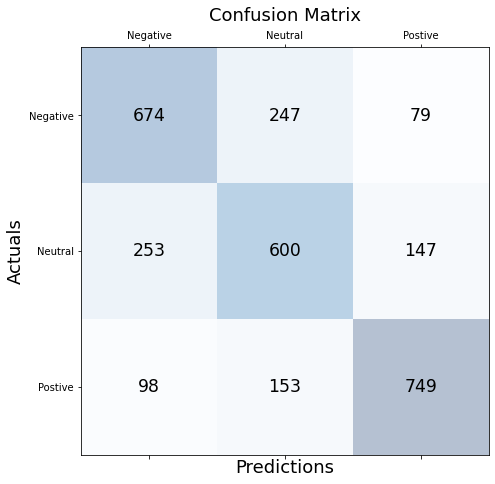

In [22]:
_,conf_matrix, y_pred = train_and_eval_model(min_df=1)
labels = ['Negative','Neutral', 'Postive']

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [23]:
y_enc

array([1, 1, 1, ..., 2, 2, 2])

In [24]:
df2 = pd.DataFrame()

df2['X_test'] =  X
df2['y_test_enc'] =  y_enc
df2['y_pred'] =  y_pred

#df2[df2["y_test_enc"]==-1 & df2["y_pred"]==1].item()

In [25]:
df2[np.logical_and.reduce([df2['y_test_enc'] == 1, df2['y_pred'] == 0])]

,X_test,y_test_enc,y_pred
0,"[nana, pleas, follow, thi, fake, new, lie, and, sue, bbc, for, peddl, fals, inform, hold, al]",1,0
1,"[no, you, havent, he, use, hi, freedom, speech, is, he, cover]",1,0
6,"[the, emoji, you, use, show, you, dont, have, sens]",1,0
8,"[whi, are, some, you, guy, be, neg, here, without, offer, solut, ani, particularli, note, problem]",1,0
11,"[yall, quick, insult]",1,0
...,...,...,...
995,"[pleas, sir, where, the, insult]",1,0
996,"[our, leader, have, fail, ghana, complet, when, can, african, leader, put, greed, asid, and, focu, their, citiz]",1,0
997,"[dear, pleas, check, well, your, darl, took, there, not, check, and, revert]",1,0
998,"[have, lot, money, account, even, lose, dont, care, cuz, ill, never, broke]",1,0


In [26]:
df.loc[852,'tweet']

'@Nicksalat_ @RailaOdinga @NAkufoAddo Tell Gideon he should also accept the results if Raila defeats him'

In [27]:
df2[df2["y_test_enc"]==-1 & df2["y_pred"]==1].item()

ValueError: ignored

# Summary

The addition of SMOTE oversampling generally improved the SVM as negative classes have better scores. 

In [ ]:
easy.py